In [1]:
!gdown --id 15Z0tkJW6NTdvi9q0G3vQDgRyniXzqEzG

Downloading...
From: https://drive.google.com/uc?id=15Z0tkJW6NTdvi9q0G3vQDgRyniXzqEzG
To: /content/diamonds.zip
100% 712k/712k [00:00<00:00, 95.2MB/s]


In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
import torch.nn as nn
from torch.nn import Sequential, Linear, LazyLinear
from torch.nn import ELU, ReLU, Tanh, Sigmoid, Softmax
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Adam, SGD
from torch.distributions import transforms as tfs
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms as tfs
import torchvision.models as models
from scipy.stats import pearsonr
from scipy import stats
from sklearn.preprocessing import QuantileTransformer, quantile_transform
import seaborn as sns
import matplotlib.pyplot as plt

#Pregunta 1

✓ En primer lugar leemos los datos y nos fijamos hacemos un análisis exploratorio de ls variables

In [3]:
df = pd.read_csv('/content/diamonds.zip')

In [4]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,Usage
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,ToV
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,Test
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,ToV
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,ToV
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,ToV


In [5]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


✓ Notemos que el minimo de las variables x, y, z son 0 lo que no es posible, por lo tanto las eliminamos

In [6]:
df2 = df.loc[(df[['x','y','z','price']]!=0).all(axis=1)]
df2.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,26972.355731,0.797698,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,15571.269010,0.473795,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,1.000000,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,13487.750000,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,26973.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40457.250000,1.040000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


✓ La columna 'Unnamed: 0' no es necesaria, puesto que no está descrita en las variables del problema y la eliminamos también

In [7]:
df3 = df2.drop(columns = 'Unnamed: 0')

In [8]:
df3

,carat,cut,color,clarity,depth,table,price,x,y,z,Usage
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,ToV
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,Test
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,ToV
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,ToV
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,ToV
...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50,ToV
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61,ToV
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56,ToV
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74,ToV


✓ Eliminamos duplicados y valores vacios si es que los hubiese

In [9]:
df3 = df3.drop_duplicates()
df3 = df3.dropna()

In [10]:
df3.describe()

,carat,depth,table,price,x,y,z
count,53801.000000,53801.000000,53801.000000,53801.000000,53801.000000,53801.000000,53801.000000
mean,0.797501,61.748518,57.457919,3930.601513,5.731516,5.734835,3.539934
std,0.473153,1.431781,2.234186,3985.375658,1.118598,1.139418,0.701996
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.030000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


✓ Para ver si dentro de la regresión del precio v/s todas las otras covariables hay una relación, hacemos un análisis de prueba p para ver la significancia de las variables dentro de la regresión.

✓ A un 90% de significancia un valor p > 0.001 nos indica que la variable no es significativa

In [11]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

In [12]:
p_values = calculate_pvalues(df3)

In [13]:
p_values

,carat,depth,table,price,x,y,z
carat,0,0,0,0,0,0,0
depth,0,0,0,0.009443,0,0,0
table,0,0,0,0,0,0,0
price,0,0.009443,0,0,0,0,0
x,0,0,0,0,0,0,0
y,0,0,0,0,0,0,0
z,0,0,0,0,0,0,0


✓ Como la variable 'depth' no es significativa en la regresión de price la eliminamos

In [14]:
df3 = df3.drop('depth',1)

✓ A continuación veremos como se distribuyen los datos de nuestro problema para así inferir en los mismos

In [15]:
def graficar_hist(df,list_variables):
  fig,axes = plt.subplots(nrows=1, ncols=len(list_variables), figsize=(20,5))
  fig.tight_layout(pad=3.0)
  counter = 0
  for ax in axes:
    sns.histplot(x = list_variables[counter], data= df, bins=30, ax = ax)
    ax.set(xlabel= list_variables[counter], ylabel='frecuencia')
    counter +=1

def graficar_scatter(df, list_variables):
  fig,axes = plt.subplots(nrows=1, ncols=len(list_variables), figsize=(20,5))
  fig.tight_layout(pad=3.0)
  counter = 0
  y = df['price']
  for ax in axes:
    sns.scatterplot(x = list_variables[counter], y = y,palette= "Blues_d", marker="+", ax = ax, data=df)
    ax.set(xlabel= list_variables[counter], ylabel='price')
    counter +=1

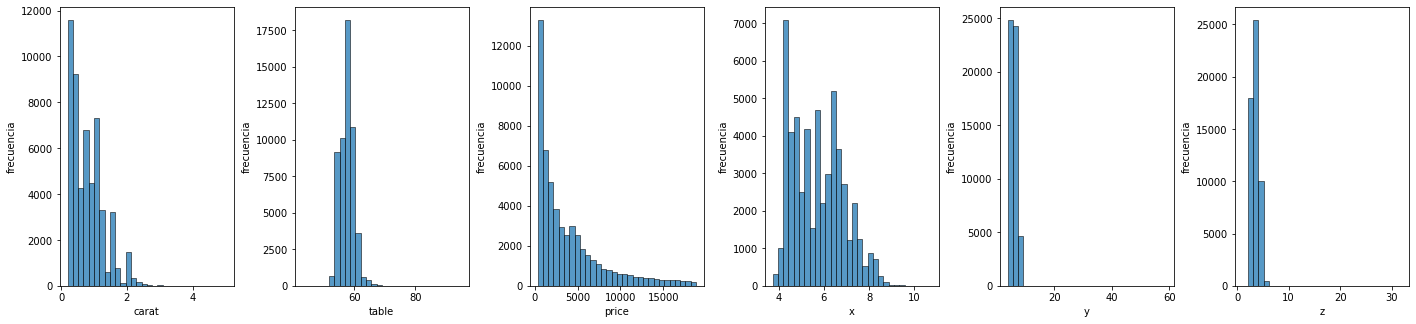

In [16]:
vars = list(df3.select_dtypes(include=[np.number]).columns)
graficar_hist(df3,vars)

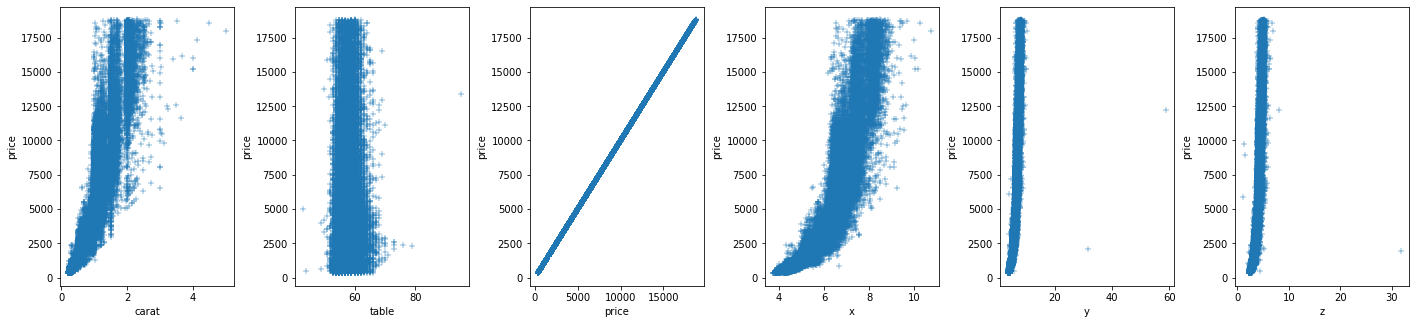

In [17]:
graficar_scatter(df3,vars)

✓ Al parecer las variables no distribuyen de forma normal y además en los graficos de dispersion se puede ver que existe una tendencia entre los datos. A pesar que esta relación no es lineal, podemos transformar las variables para obtener un mejor ajuste y inferir de mejor manera

In [18]:
df5 = pd.DataFrame(columns=['carat','cut','color','clarity','table','price','x','y','z'])
df3.dropna()
for i in df3.columns:
  if (i != 'price') and (i != 'cut') and (i != 'color') and (i != 'clarity') and (i != 'Usage'):
    fitted_data = (df3[i]**(1/3))
    df5[i] = fitted_data
  elif i == 'price':
    df5[i] = np.log(df3[i])
  else:
    df5[i] = df3[i]

✓ Si transformamos la variable 'price' con la funcion f(x) = log(x) y el resto de las covariables las elevamos a 1/3 es posible notar que se logra una mejor calidad en el ajuste y por tanto, usaremos estas variables transformadas.

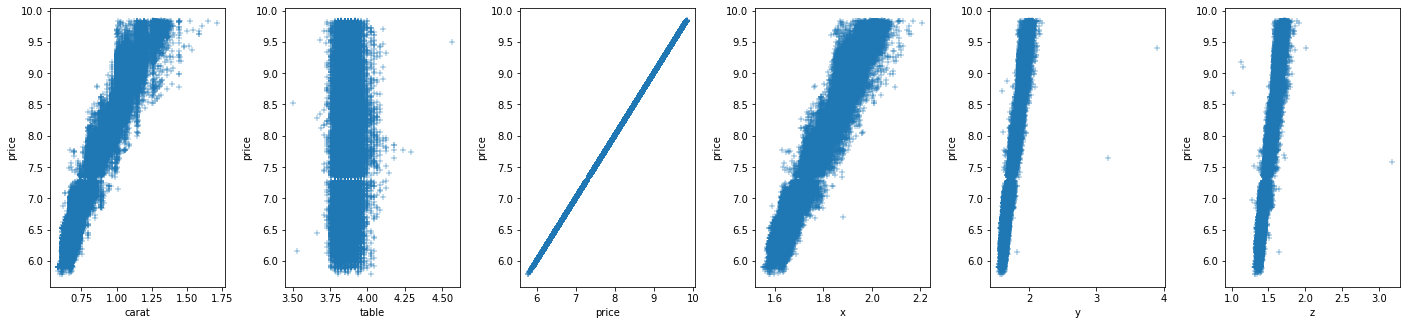

In [19]:
graficar_scatter(df5,vars)

✓ A continuacion vemos el comportamiento de las variables no numericas y vemos como aumenta o disminuye price a medida que aumentan o disminuyen las covariables.

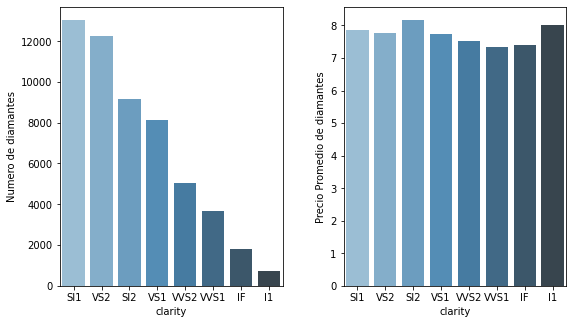

In [20]:
IF = df5[df5['clarity'] == 'IF']
VVS1 = df5[df5['clarity'] == 'VVS1']
VVS2 = df5[df5['clarity'] == 'VVS2']
VS1 = df5[df5['clarity'] == 'VS1']
VS2 = df5[df5['clarity'] == 'VS2']
SI1 = df5[df5['clarity'] == 'SI1']
I1 = df5[df5['clarity'] == 'I1']
SI2 = df5[df5['clarity'] == 'SI2']
fig, axes = plt.subplots(1, 2, figsize=(8.3,5))
fig.tight_layout(pad=3.0)
etiquetas = ['SI1', 'VS2','SI2', 'VS1', 'VVS2', 'VVS1', 'IF','I1']
cantidad = [SI1.shape[0], VS2.shape[0],SI2.shape[0],VS1.shape[0], VVS2.shape[0], VVS1.shape[0], IF.shape[0],I1.shape[0],]
promedios = [SI1['price'].mean(), VS2['price'].mean(), SI2['price'].mean(),  VS1['price'].mean(), VVS2['price'].mean(), VVS1['price'].mean(), IF['price'].mean(),I1['price'].mean()]
sns.barplot(x = etiquetas, y = cantidad, color='#0C2C40', ax=axes[0], palette="Blues_d")
sns.barplot(x = etiquetas, y = promedios,color='#325A73', ax=axes[1], palette="Blues_d")
axes[0].set(xlabel='clarity', ylabel='Numero de diamantes')
axes[1].set(xlabel='clarity', ylabel='Precio Promedio de diamantes')
sns.set_theme(style="whitegrid")
plt.show()

✓ Notemos que el precio es alto en cateogrias como I1 y SI2 y bajo en otras como en IF y VVS1

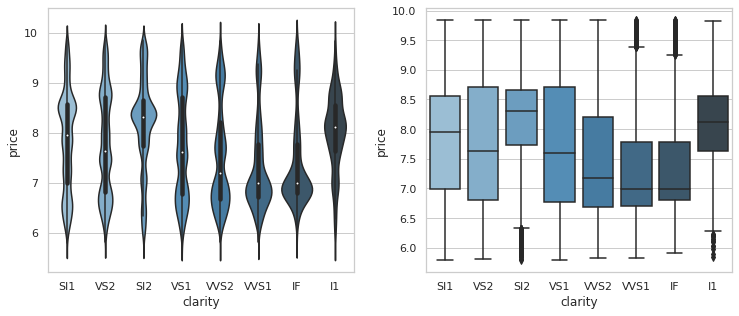

In [21]:
fig, axes = plt.subplots(1, 2,figsize=(11,5))
fig.tight_layout(pad=3.0)
violin_box_clarity = sns.violinplot(x="clarity", y="price", order = ['SI1', 'VS2','SI2', 'VS1', 'VVS2', 'VVS1', 'IF','I1'] , data=df5,ax=axes[0], palette="Blues_d")
box_clarity = sns.boxplot(x="clarity", y="price", order = ['SI1', 'VS2','SI2', 'VS1', 'VVS2', 'VVS1', 'IF','I1'] , data=df5,ax=axes[1], palette="Blues_d")

✓ Las medias se distribuyen en un rango semi uniforme y categorias como IF SI2 Y VVS1 cuentan con un mayor numero de observaciones atipicas

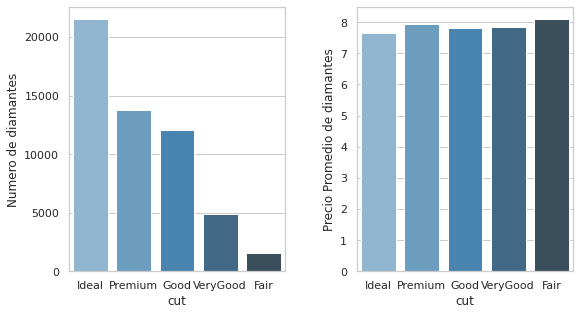

In [22]:
Fair = df5[df5['cut'] == 'Fair']
Good = df5[df5['cut'] == 'Good']
Verygood = df5[df5['cut'] == 'Very Good']
Premium = df5[df5['cut'] == 'Premium']
Ideal = df5[df5['cut'] == 'Ideal']
fig, axes = plt.subplots(1, 2, figsize=(8.5,5))
fig.tight_layout(pad=3.0)
etiquetas = ['Ideal', 'Premium', 'Good', 'VeryGood', 'Fair']
cantidad = [Ideal.shape[0], Premium.shape[0], Verygood.shape[0], Good.shape[0], Fair.shape[0]]
promedios = [Ideal['price'].mean(), Premium['price'].mean(), Verygood['price'].mean(), Good['price'].mean(), Fair['price'].mean()]
sns.barplot(x = etiquetas, y = cantidad, ax=axes[0], palette="Blues_d")
sns.barplot(x = etiquetas, y = promedios,ax=axes[1], palette="Blues_d")
axes[0].set(xlabel='cut', ylabel='Numero de diamantes')
axes[1].set(xlabel='cut', ylabel='Precio Promedio de diamantes')
sns.set_theme(style="whitegrid")

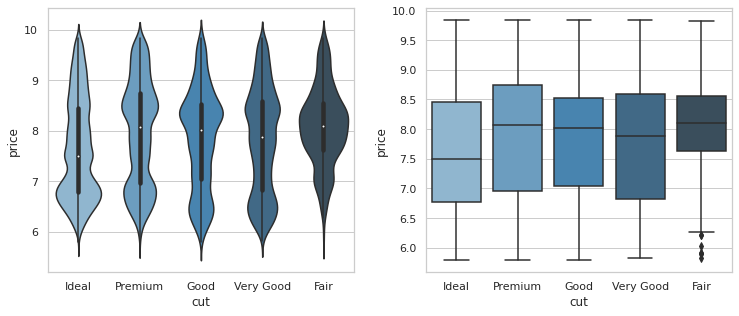

In [23]:
fig, axes = plt.subplots(1, 2,figsize=(11,5))
fig.tight_layout(pad=3.0)
violin_box_clarity = sns.violinplot(x="cut", y="price", order = ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'] , data=df5,ax=axes[0], palette="Blues_d")
box_clarity = sns.boxplot(x="cut", y="price", order = ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'] , data=df5,ax=axes[1], palette="Blues_d")

✓ En cuanto al crote, tambien las medias se distribuyen en un intervalo uniforme y notamos que no hay una presencia de mucho valores atipicos que superen el percentil 75. El unico que cuenta con estos datos es la categoria 'FAIR' que es precisamente en la que se obtienen mejores precios

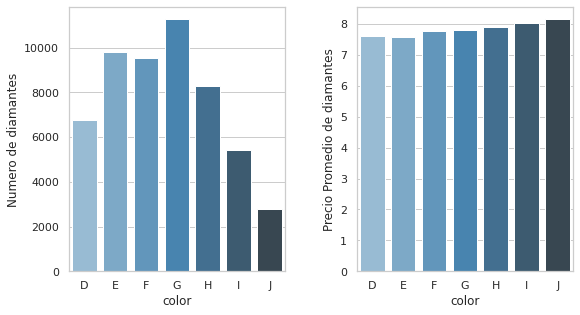

In [24]:
D = df5[df5['color'] == 'D']
E = df5[df5['color'] == 'E']
F = df5[df5['color'] == 'F']
G = df5[df5['color'] == 'G']
H = df5[df5['color'] == 'H']
I = df5[df5['color'] == 'I']
J = df5[df5['color'] == 'J']
fig, axes = plt.subplots(1, 2, figsize=(8.5,5))
fig.tight_layout(pad=3.0)
etiquetas = ['D', 'E', 'F', 'G', 'H','I','J']
cantidad = [D.shape[0], E.shape[0], F.shape[0], G.shape[0], H.shape[0], I.shape[0], J.shape[0]]
promedios = [D['price'].mean(), E['price'].mean(), F['price'].mean(), G['price'].mean(), H['price'].mean(), I['price'].mean(), J['price'].mean(),]
sns.barplot(x = etiquetas, y = cantidad, ax=axes[0], palette="Blues_d")
sns.barplot(x = etiquetas, y = promedios,ax=axes[1], palette="Blues_d")
axes[0].set(xlabel='color', ylabel='Numero de diamantes')
axes[1].set(xlabel='color', ylabel='Precio Promedio de diamantes')
sns.set_theme(style="whitegrid")

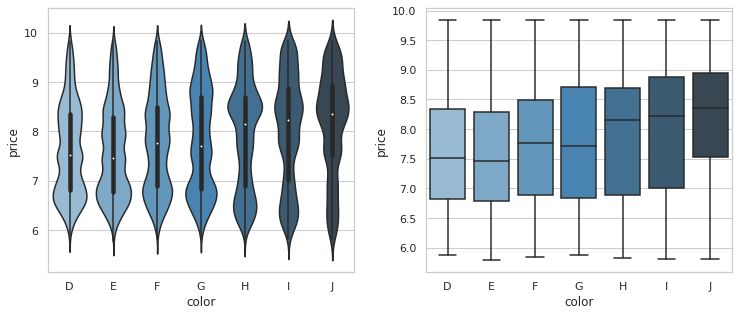

In [25]:
fig, axes = plt.subplots(1, 2,figsize=(11,5))
fig.tight_layout(pad=3.0)
violin_box_clarity = sns.violinplot(x="color", y="price", order = ['D', 'E', 'F', 'G', 'H','I','J'], data=df5,ax=axes[0], palette="Blues_d")
box_clarity = sns.boxplot(x="color", y="price", order = ['D', 'E', 'F', 'G', 'H','I','J'] , data=df5,ax=axes[1], palette="Blues_d")

✓ En cuanto al color existe una fuerte relacion lineal entre las categorias y el precio, observando que el precio aumenta a medida que la letra  del alfabeto.

✓ Finalmente transformamos las variables no numericas a un valor numerico, otorgando mayores numeros a los elementos de categoria que tienen mayor valor de precio asociado y menor valor de numero a los que tienen menor valor de precio.

In [26]:
df6 = df5.replace({'Ideal': 1, 'Premium': 4, 'Very Good': 3, 'Good': 2, 'Fair': 5})

In [27]:
df6 = df6.replace({'D': 2, 'E': 1, 'F': 5, 'G': 3, 'H': 6, 'I': 4, 'J': 7})

In [28]:
df6 = df6.replace({'IF': 2, 'VVS1': 1, 'VVS2': 3, 'VS1': 4, 'VS2': 5, 'SI1': 6, 'SI2': 8, 'I1': 7})

✓ Para eliminar outliers, realizamos la prueba de estadistico Z, la cual nos permite eliminar puntos que a un cierto nivel de la desviación estandar.

In [29]:
def eliminar_outliers(df, list_variables, z):
    for var in list_variables:
        df1 = df[np.abs(stats.zscore(df[var])) < z]
    return df1

✓ Eliminamos los datos que esten por sobre 1.5 unidades en la deviacion estandar.

In [30]:
vars = list(df6.select_dtypes(include=[np.number]).columns)
df6 = eliminar_outliers(df6, vars, 0.7)

In [31]:
df7 = pd.DataFrame(columns=['carat','cut','color','clarity','table','price','x','y','z','Usage'])
for i in df6.columns:
  if (i != 'price') and (i != 'Usage'):
    fitted_data = quantile_transform(df6[i].to_frame(),
                             n_quantiles=5000,
                             output_distribution='normal',
                             copy=True).squeeze()
    df7[i] = fitted_data
  else:
    df7[i] = df6[i]

✓ Como se pudo notar anteriormente, los datos no seguian una distribución normal estandar, por lo mismo, es importante hacer esta estrategia de procesamiento de datos ya que la normalización generalmente aumenta la velocidad del aprendizaje y nos ayuda a tener un mejor rendimiento.

✓ Todo esto debido a que la normalizacion, al tener una media de valores cercanos a cero existen valores positivos y negativos lo que nos ayuda al aprendizaje

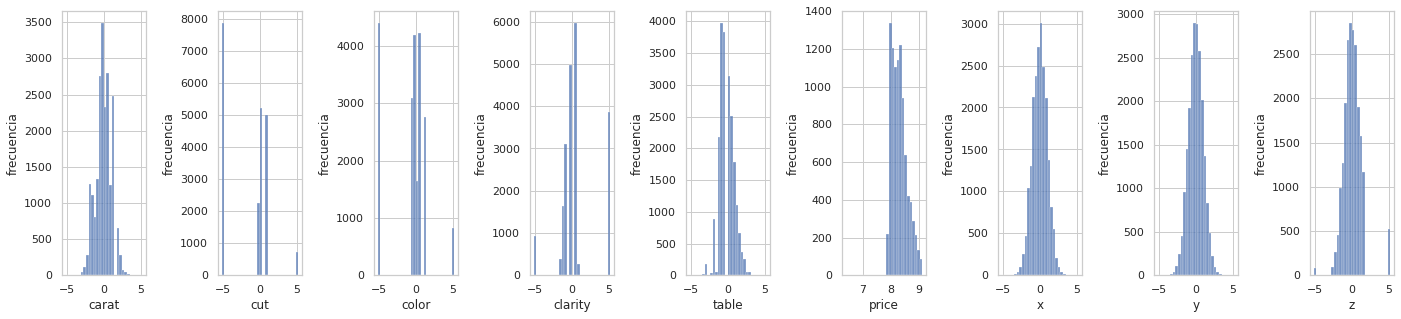

In [32]:
graficar_hist(df7,vars)

In [33]:
listvar = ['carat','cut','color','clarity']
listresp = ['price']
def construir_x_y(df,listvar,listresp):
  df_copy = df.copy(deep=True)
  x = df_copy[listvar].to_numpy()
  y = df_copy[listresp].to_numpy()
  return x,y

In [34]:
df_test = df7[df7['Usage'] == 'Test']
df_Tov = df7[df7['Usage'] == 'ToV']

In [35]:
df_test = df7[df7['Usage'] == 'Test']
df_Tov = df7[df7['Usage'] == 'ToV']

✓ Observamos los datos de la matriz de entrenamiento y test

In [36]:
df_test.shape

(949, 10)

In [37]:
df_Tov.shape

(8382, 10)

In [38]:
X_test, Y_test = construir_x_y(df_test,listvar,listresp)

In [39]:
X_tov , Y_tov = construir_x_y(df_Tov,listvar,listresp)

✓ Generamos el Tensor

In [40]:
sets = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))

✓ Dividimos los datos de tov en el conjunto de entrenamiento y validación de forma aleatoria en una razón de 80%  y 20% respectivamente.

✓ Lo anteriormente mencionado viene de la aplicación misma del principio de  Pareto que menciona que dentro de una muestra el 80% de los datos provienen como consecuencia de un 20% de otros.

In [41]:
X_rows = X_test.shape[0]
train_size = int(X_rows*0.80)
val_size = X_rows - train_size

In [42]:
train_set, validation_set = random_split(sets, [train_size, val_size]) 

✓ Vemos el tamaño de ambas matrices

In [43]:
train_size

759

In [44]:
val_size

190

In [45]:
X_train_loader = DataLoader(train_set, 32, shuffle=True)
X_validate_loader = DataLoader(validation_set, 32*2)

✓ Creamos la clase del perceptron multicapa

In [46]:
class Mod_regresion_lineal(nn.Module):
    def __init__(self, indim, outdim, hiddendim,hiddendim1, fun):
        super().__init__()
        ###capa entrada
        self.linear1 = nn.Linear(indim, hiddendim)
        self.batch1 = nn.BatchNorm1d(hiddendim)
        self.elu1 = fun
        self.drop1 = nn.Dropout(0.5)
        ###capa oculta
        self.linear2 = nn.Linear(hiddendim, hiddendim1)
        self.batch2 = nn.BatchNorm1d(hiddendim1)
        self.elu2 = fun
        self.drop2 = nn.Dropout(0.3)
        ### capa salida
        self.linear3 = nn.Linear(hiddendim1, outdim)
        
    def forward(self, x):
        #k1 = self.cnn(x)
        z1 = self.linear1(x)
        z2 = self.batch1(z1)
        y1 = self.elu1(z2)
        y2 = self.drop1(y1)
        # Capa oculta
        z3 = self.linear2(y2)
        z4 = self.batch2(z3)
        y3 = self.elu2(z4)
        y4 = self.drop2(y3)
        # Capa salida
        out = self.linear3(y2)
        return out

    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)  
        loss_f = nn.MSELoss()        
        loss = loss_f(out,targets)    
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs) 
        loss_f = nn.MSELoss()           
        loss = loss_f(out,targets)
        return {'funcion perdida': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['funcion perdida'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        return {'funcion perdida': epoch_loss.item()}

    def epoch_end(self, epoch, result, accuralist):
        print("Epoch [{}], funcion perdida:{:.4f}, MAE:{:.4f}, MSE: {:.4f}".format(epoch+1, result['funcion perdida'], accuralist[0], accuralist[1]))

In [47]:
input_dim = 4
hidden_dim = 60
hidden_dim1 = 60
output_dim = 1
model = Mod_regresion_lineal(input_dim,output_dim,hidden_dim,hidden_dim1, nn.ELU())
model1 = Mod_regresion_lineal(input_dim,output_dim,hidden_dim,hidden_dim1, nn.ReLU())
model2 = Mod_regresion_lineal(input_dim,output_dim,hidden_dim,hidden_dim1, nn.Tanh())
model3 = Mod_regresion_lineal(input_dim,output_dim,hidden_dim,hidden_dim1, nn.Sigmoid())

✓ Se evalua y entrenan los modelos

In [61]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def accuracy(model, val_loader):
    predictions_valid = [ model(xb).detach().squeeze(1).numpy() for xb,yb in val_loader]
    y_pred_valid = [elem for pred in predictions_valid for elem in pred]
    y_true_valid = [(ytrue).item() for xb,yb in val_loader for ytrue in yb]
    difference_mae = sum([np.abs(np.exp(x1) - np.exp(x2)) for (x1, x2) in zip(y_pred_valid, y_true_valid)])/len(y_pred_valid)
    rmse = np.sqrt(sum([(np.exp(x1) - np.exp(x2))**2 for (x1, x2) in zip(y_pred_valid, y_true_valid)])/len(y_pred_valid))
    return [difference_mae,rmse]

def fit(epochs, lr, model, train_loader, val_loader):
    history = []
    optimizer = torch.optim.Adam(model.parameters(), lr)
    for epoch in range(epochs):
        #entrenamiento
        for batch in train_loader:
          loss = model.training_step(batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        #validacion
        result = evaluate(model, val_loader)
        acclist = accuracy(model, val_loader)
        history.append((result, acclist))
    model.epoch_end(epoch, result, acclist)
    return history

In [49]:
result = evaluate(model, X_validate_loader)
result

{'funcion perdida': 66.79559326171875}

In [50]:
epochs = 500
lr = 1e-2
history = fit(epochs, lr, model, X_train_loader, X_validate_loader)

Epoch [500], funcion perdida:0.0648, MAE:825.3091, MSE: 1204.6026


In [51]:
epochs = 400
history1 = fit(epochs, lr, model1, X_train_loader, X_validate_loader)

Epoch [400], funcion perdida:0.0641, MAE:803.7286, MSE: 1210.0685


In [52]:
epochs = 500
history2 = fit(epochs, lr, model2, X_train_loader, X_validate_loader)

Epoch [500], funcion perdida:0.0666, MAE:826.0575, MSE: 1180.0711


In [53]:
epochs = 500
lr = 1e-2
history3 = fit(epochs, lr, model3, X_train_loader, X_validate_loader)

Epoch [500], funcion perdida:0.0615, MAE:777.8037, MSE: 1190.0173


✓ Se realizaron pruebas para 5 pares de neuronas intermedias y de entrada y los datos segun cada activacion se muestran a continuación: 

✓ Función RELU:

Par de Puntos  | MAE | MSE
-------------------|-------|-----------
4,3     | 873| 1360
4,10       | 902| 1267
4,60 | 855|1329
4,80 | 896| 1253
4,150 | 984| 1334

✓ Función TANH:

Par de Puntos  | MAE| MSE
-------------------|-----|-------------
4,3     | 823|1263
4,10       | 843| 1254
4,60 | 839| 1233
4,80 | 905|1345
4,150 | 991|1369

✓ Función SIGMOID:

Par de Puntos  | MAE | MSE
-------------------|------|------------
4,3     | 890|1221
4,10       | 832| 1245
4,60 | 764| 1162
4,80 | 877|1257
4,150 | 903|1342

✓ Por lo tanto el mejor modelo es la función Sigmoide con 4 y 80 neuronas respectivamente.


✓ Probamos el mejor modelo en set de test agregando dos capas intermedias

In [62]:
class Mod_regresion_lineal2(nn.Module):
    def __init__(self, indim, outdim, hiddendim,hiddendim1,fun):
        super().__init__()
        ###capa entrada
        self.linear1 = nn.Linear(indim, hiddendim)
        self.batch1 = nn.BatchNorm1d(hiddendim)
        self.elu1 = fun
        self.drop1 = nn.Dropout(0.5)
        ###capa 2
        self.linear2 = nn.Linear(hiddendim, hiddendim)
        self.batch2 = nn.BatchNorm1d(hiddendim)
        self.elu2 = fun
        self.drop2 = nn.Dropout(0.5)
        ####capa3
        self.linear3 = nn.Linear(hiddendim, hiddendim)
        self.batch3 = nn.BatchNorm1d(hiddendim)
        self.elu3 = fun
        self.drop3 = nn.Dropout(0.5)
        ###capa oculta
        self.linear4 = nn.Linear(hiddendim, hiddendim)
        self.batch4 = nn.BatchNorm1d(hiddendim)
        self.elu4 = fun
        self.drop4 = nn.Dropout(0.3)
        ### capa salida
        self.linear5 = nn.Linear(hiddendim, outdim)
        
    def forward(self, x):
        z1 = self.linear1(x)
        z2 = self.batch1(z1)
        y1 = self.elu1(z2)
        y2 = self.drop1(y1)
        ### capa 1
        z3 = self.linear2(y2)
        z4 = self.batch2(z3)
        y3 = self.elu2(z4)
        y4 = self.drop2(y3)
        ### capa 2
        z5 = self.linear3(y4)
        z6 = self.batch3(z5)
        y5 = self.elu3(z6)
        y6 = self.drop3(y5)
        #### capa intermedia
        z7 = self.linear4(y6)
        z8 = self.batch4(z7)
        y7 = self.elu4(z8)
        y8 = self.drop4(y7)
        # Capa salida
        out = self.linear5(y8)
        return out

    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)  
        loss_f = nn.MSELoss()        
        loss = loss_f(out,targets)    
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs) 
        loss_f = nn.MSELoss()           
        loss = loss_f(out,targets)
        return {'validation_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        return {'validation_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, accuralist):
        print("Epoch [{}], validation_loss:{:.4f}, MAE:{:.4f}, MSE: {:.4f}".format(epoch+1, result['validation_loss'], accuralist[0], accuralist[1]))

In [63]:
input_dim = 4
hidden_dim = 150
hidden_dim1 = 150
output_dim = 1
model = Mod_regresion_lineal2(input_dim,output_dim,hidden_dim,hidden_dim1, nn.Sigmoid())

In [64]:
epochs = 500
lr = 1e-2
history = fit(epochs, lr, model, X_train_loader, X_validate_loader)

Epoch [500], validation_loss:0.0581, MAE:534.5593, MSE: 1108.6475


# Referencias Bibliograficas

 1. Sindiri, V. (2020, June 16). Diamond price prediction based on their cut, colour, clarity, price with PyTorch. Medium. https://towardsdatascience.com/diamond-price-prediction-based-on-their-cut-colour-clarity-price-with-pytorch-1e0353d2503b